## 1. 任务介绍
> 介绍任务的基本内容，以及问题的公式化
---
文本分类是自然语言处理中最基础的任务之一，主要是通过分类器将给定的文本划分到特定的类，比如情绪分类、垃圾邮件分类、电影评论分类等。具体任务公式化如下：
$$
\begin{aligned}
文本 ： &X = (x_1,x_2,\dots,x_n) \\
类标签 ：& Y = (y_1,y_2,\dots,y_n)\\
模型 ：& f: x_i  \xrightarrow{f} y_i, \hspace{1em} i = 1,2, \dots,n
\end{aligned}
$$
本文选用Kaggle的电影评论情感分析来作为任务。

## 2.环境准备

In [9]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics 

import nltk
from nltk.corpus import stopwords

N_CLASSES = 2 # 类别数

## 3. 数据预处理
> 需要对数据进行清洗
---

处理步骤大致如下：
    1. 去除html标签
    2. 去除标点
    3. 切分成词
    4. 去除停用词
    5. 重组为新的句子

In [2]:
# 0. 先准备数据
file_path = '../data/IMDB/labeledTrainData.tsv'
df = pd.read_csv(file_path,sep='\t',escapechar='\\')
print('Number of samples:{}'.format(len(df)))
df.head()

Number of samples:25000


,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"""The Classic War of the Worlds"" by Timothy Hin..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [3]:
eng_stopwords = stopwords.words('english') #定义停用词

def text_clean(text):
    text = BeautifulSoup(text,'html.parser').get_text() #去除html标签
    text = re.sub(r'[^a-zA-Z]',' ',text) #去除标点
    words = text.lower().split()  #全部转成小写，然后按空格分词
    words = [w for w in words if w not in eng_stopwords] #去除停用词
    return ' '.join(words)  #重组成新的句子

df['clean_review'] = df.review.apply(text_clean)
df.head()

,id,sentiment,review,clean_review
0,5814_8,1,With all this stuff going down at the moment w...,stuff going moment mj started listening music ...
1,2381_9,1,"""The Classic War of the Worlds"" by Timothy Hin...",classic war worlds timothy hines entertaining ...
2,7759_3,0,The film starts with a manager (Nicholas Bell)...,film starts manager nicholas bell giving welco...
3,3630_4,0,It must be assumed that those who praised this...,must assumed praised film greatest filmed oper...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...,superbly trashy wondrously unpretentious explo...


## 4. 文本特征表示 
> 文本向量化，并提取特征，分为离散法和分布式法(此处主要讲离散法)
---
离散法主要有以下几种方法：
 1. 词袋模型(Bag of word): 用单词频数来表示文本，不考虑文本的语法结构和单词顺序
 2. 独热编码(One-hot): 将文本表示成整个词标长度的向量，出现过的词为1，否则为0
 3. n元语法(n-gram): 对词袋模型的一种改进，即用n个词或词组组成的字符串作为特征，然后再用词袋模型的方法将文本表示为向量形式
 4. TF-IDF： 用词的TF-IDF来表示文本
 
<span style="color:red">注：其实上述方法都可以看作是词袋模型</span>

In [4]:
# 1. 使用统计词频，作为文本特征
vectorizer_feq = CountVectorizer(max_features=5000) #取词频为前5000的词
data_freq = vectorizer_feq.fit_transform(df.clean_review).toarray()
print("词频为特征的文本-单词矩阵维度:",data_freq.shape)

# 2. 使用bigram，作为文本特征
vectorizer_bigram = CountVectorizer(ngram_range=(2,2),max_features=1000,token_pattern=r'\b\w+\b', min_df=1)
# analyze = vectorizer_bigram.build_analyzer()
# print("bi-gram示例：",analyze(df.clean_review[0]))#bi-gram举例
data_bigram = vectorizer_bigram.fit_transform(df.clean_review).toarray()
print("bi-gram为特征的文本-单词矩阵维度：",data_bigram.shape)

# 2. 使用tfidf, 作为文本特征
vectorizer_tfidf = TfidfVectorizer(max_features=5000)
data_tfidf = vectorizer_tfidf.fit_transform(df.clean_review).toarray()

print("TF-IDF为特征的文本-单词矩阵维度：",data_tfidf.shape)

词频为特征的文本-单词矩阵维度: (25000, 5000)
bi-gram为特征的文本-单词矩阵维度： (25000, 1000)
TF-IDF为特征的文本-单词矩阵维度： (25000, 5000)


## 5. 辅助函数
> 包括数据批量生成器，softmax函数，预测函数，评估函数

In [5]:
# 定义数据批量生成器
def batch_generator(data, batch_size, shuffle=True):
    X, Y = data
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    if shuffle:
        np.random.shuffle(indices)  # 打乱顺序

    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        batch_idx = indices[start:end]

        yield X[batch_idx], Y[batch_idx]


# softmax函数
def softmax(scores):
    sum_exp = np.sum(np.exp(scores), axis=1, keepdims=True)
    softmax = np.exp(scores) / sum_exp
    return softmax


# 预测函数
def predict(w, b, x):
    scores = np.dot(x, w.T) + b
    probs = softmax(scores)

    return np.argmax(probs, axis=1).reshape(-1, 1)


# 将数据集分割
def split_data(x, y, val_split=0.2):
    n_samples = x.shape[0]

    indices = np.random.permutation(n_samples)
    split = int(n_samples * (1 - val_split))
    training_idx = indices[:split]
    valid_idx = indices[split + 1:]

    train_x = x[training_idx]
    train_y = y[training_idx]

    valid_x = x[valid_idx]
    valid_y = y[valid_idx]

    return train_x, train_y, valid_x, valid_y

## 6. 构建分类器
> 此处以softmax regression作为分类器

In [6]:
def valid(w, val_x, val_y, batch_size=64):
    val_loss = []
    val_gen = batch_generator((val_x, val_y), batch_size, shuffle=False)

    for batch_x, batch_y in val_gen:
        scores = np.dot(batch_x, w.T)
        prob = softmax(scores)

        y_one_hot = np.eye(N_CLASSES)[batch_y]
        # 损失函数
        loss = -(1.0 / len(batch_x)) * np.sum(y_one_hot * np.log(prob))
        val_loss.append(loss)

    return np.mean(val_loss)


def train(train_x,
          train_y,
          valid_x,
          valid_y,
          lr=0.01,
          batch_size=128,
          epochs=5000,
          early_stop=None):

    n_features = train_x.shape[1]
    w = np.random.rand(N_CLASSES, n_features)

    train_all_loss = []
    val_all_loss = []

    not_improved = 0
    best_val_loss = np.inf
    best_w = None

    for epoch in range(epochs):
        training_gen = batch_generator((train_x, train_y), batch_size)
        train_loss = []
        for batch_x, batch_y in training_gen:
            scores = np.dot(batch_x, w.T)
            prob = softmax(scores)

            y_one_hot = np.eye(N_CLASSES)[batch_y]
            # 损失函数
            loss = -(1.0 / len(batch_x)) * np.sum(y_one_hot * np.log(prob))
            train_loss.append(loss)

            # 梯度下降
            dw = -(1.0 / len(batch_x)) * np.dot((y_one_hot - prob).T, batch_x)
            w = w - lr * dw

        val_loss = valid(w, valid_x, valid_y)

        print("Epoch = {0},the train loss = {1:.4f}, the val loss = {2:.4f}".
              format(epoch, np.mean(train_loss), val_loss))

        train_all_loss.append(np.mean(train_loss))
        val_all_loss.append(val_loss)

        if early_stop is not None:
            if val_loss <= best_val_loss:
                best_val_loss = val_loss
                best_w = w
                not_improved = 0
            else:
                not_improved += 1

            if not_improved > early_stop:
                print("Validation performance didn\'t improve for {} epochs. "
                      "Training stops.".format(early_stop))
                break

    return best_w, train_all_loss, val_all_loss

## 7.训练 

### 7.1 以BOW为特征进行训练 

In [8]:
label = df['sentiment'].values

train_x, trian_y, val_x, val_y = split_data(data_freq, label)

w, train_all_loss, val_all_loss = train(
        train_x, trian_y, val_x, val_y, early_stop=10)

Epoch = 0,the train loss = 1.8074, the val loss = 1.5980
Epoch = 1,the train loss = 1.5201, the val loss = 1.4091
Epoch = 2,the train loss = 1.3679, the val loss = 1.2844
Epoch = 3,the train loss = 1.2552, the val loss = 1.1909
Epoch = 4,the train loss = 1.1715, the val loss = 1.1201
Epoch = 5,the train loss = 1.1016, the val loss = 1.0607
Epoch = 6,the train loss = 1.0474, the val loss = 1.0138
Epoch = 7,the train loss = 1.0002, the val loss = 0.9737
Epoch = 8,the train loss = 0.9586, the val loss = 0.9396
Epoch = 9,the train loss = 0.9216, the val loss = 0.9103
Epoch = 10,the train loss = 0.8870, the val loss = 0.8846
Epoch = 11,the train loss = 0.8605, the val loss = 0.8619
Epoch = 12,the train loss = 0.8352, the val loss = 0.8420
Epoch = 13,the train loss = 0.8101, the val loss = 0.8232
Epoch = 14,the train loss = 0.7897, the val loss = 0.8075
Epoch = 15,the train loss = 0.7698, the val loss = 0.7927
Epoch = 16,the train loss = 0.7541, the val loss = 0.7779
Epoch = 17,the train los

Epoch = 141,the train loss = 0.3050, the val loss = 0.4543
Epoch = 142,the train loss = 0.3044, the val loss = 0.4538
Epoch = 143,the train loss = 0.3035, the val loss = 0.4532
Epoch = 144,the train loss = 0.3026, the val loss = 0.4527
Epoch = 145,the train loss = 0.3014, the val loss = 0.4522
Epoch = 146,the train loss = 0.3011, the val loss = 0.4514
Epoch = 147,the train loss = 0.2996, the val loss = 0.4509
Epoch = 148,the train loss = 0.3003, the val loss = 0.4503
Epoch = 149,the train loss = 0.2987, the val loss = 0.4497
Epoch = 150,the train loss = 0.2974, the val loss = 0.4493
Epoch = 151,the train loss = 0.2965, the val loss = 0.4486
Epoch = 152,the train loss = 0.2977, the val loss = 0.4482
Epoch = 153,the train loss = 0.2962, the val loss = 0.4477
Epoch = 154,the train loss = 0.2938, the val loss = 0.4473
Epoch = 155,the train loss = 0.2932, the val loss = 0.4465
Epoch = 156,the train loss = 0.2927, the val loss = 0.4464
Epoch = 157,the train loss = 0.2922, the val loss = 0.44

Epoch = 280,the train loss = 0.2284, the val loss = 0.4093
Epoch = 281,the train loss = 0.2280, the val loss = 0.4092
Epoch = 282,the train loss = 0.2275, the val loss = 0.4089
Epoch = 283,the train loss = 0.2275, the val loss = 0.4090
Epoch = 284,the train loss = 0.2274, the val loss = 0.4086
Epoch = 285,the train loss = 0.2271, the val loss = 0.4086
Epoch = 286,the train loss = 0.2266, the val loss = 0.4085
Epoch = 287,the train loss = 0.2269, the val loss = 0.4085
Epoch = 288,the train loss = 0.2264, the val loss = 0.4079
Epoch = 289,the train loss = 0.2265, the val loss = 0.4080
Epoch = 290,the train loss = 0.2255, the val loss = 0.4075
Epoch = 291,the train loss = 0.2257, the val loss = 0.4075
Epoch = 292,the train loss = 0.2250, the val loss = 0.4072
Epoch = 293,the train loss = 0.2246, the val loss = 0.4070
Epoch = 294,the train loss = 0.2245, the val loss = 0.4071
Epoch = 295,the train loss = 0.2233, the val loss = 0.4070
Epoch = 296,the train loss = 0.2245, the val loss = 0.40

Epoch = 419,the train loss = 0.1968, the val loss = 0.3946
Epoch = 420,the train loss = 0.1961, the val loss = 0.3942
Epoch = 421,the train loss = 0.1950, the val loss = 0.3943
Epoch = 422,the train loss = 0.1952, the val loss = 0.3942
Epoch = 423,the train loss = 0.1950, the val loss = 0.3943
Epoch = 424,the train loss = 0.1945, the val loss = 0.3941
Epoch = 425,the train loss = 0.1948, the val loss = 0.3940
Epoch = 426,the train loss = 0.1947, the val loss = 0.3941
Epoch = 427,the train loss = 0.1938, the val loss = 0.3941
Epoch = 428,the train loss = 0.1941, the val loss = 0.3937
Epoch = 429,the train loss = 0.1936, the val loss = 0.3935
Epoch = 430,the train loss = 0.1942, the val loss = 0.3935
Epoch = 431,the train loss = 0.1940, the val loss = 0.3939
Epoch = 432,the train loss = 0.1939, the val loss = 0.3935
Epoch = 433,the train loss = 0.1938, the val loss = 0.3934
Epoch = 434,the train loss = 0.1930, the val loss = 0.3934
Epoch = 435,the train loss = 0.1934, the val loss = 0.39

Epoch = 558,the train loss = 0.1764, the val loss = 0.3898
Epoch = 559,the train loss = 0.1763, the val loss = 0.3895
Epoch = 560,the train loss = 0.1762, the val loss = 0.3897
Epoch = 561,the train loss = 0.1767, the val loss = 0.3892
Epoch = 562,the train loss = 0.1758, the val loss = 0.3894
Epoch = 563,the train loss = 0.1761, the val loss = 0.3894
Epoch = 564,the train loss = 0.1758, the val loss = 0.3894
Epoch = 565,the train loss = 0.1756, the val loss = 0.3895
Epoch = 566,the train loss = 0.1757, the val loss = 0.3894
Epoch = 567,the train loss = 0.1756, the val loss = 0.3894
Epoch = 568,the train loss = 0.1753, the val loss = 0.3894
Epoch = 569,the train loss = 0.1761, the val loss = 0.3893
Epoch = 570,the train loss = 0.1752, the val loss = 0.3896
Epoch = 571,the train loss = 0.1756, the val loss = 0.3893
Epoch = 572,the train loss = 0.1753, the val loss = 0.3892
Validation performance didn't improve for 10 epochs. Training stops.


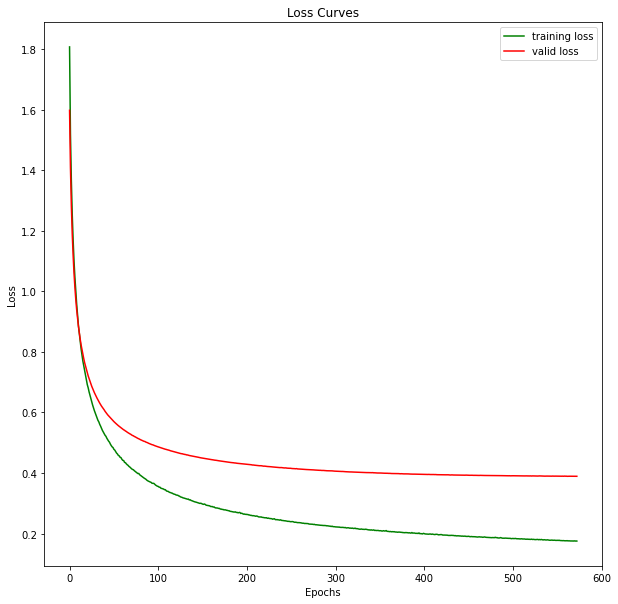

In [14]:
plt.figure(figsize=(10,10))
plt.title('Loss Curves')
plt.plot(
    np.arange(len(train_all_loss)),
              train_all_loss,
              color='green',
              label='training loss')
plt.plot(
    np.arange(len(val_all_loss)), val_all_loss, color='red',
              label='valid loss')
plt.legend()  # 显示图例

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## 参考链接
https://www.cnblogs.com/Luv-GEM/p/10888026.html

https://zhuanlan.zhihu.com/p/98061179

https://github.com/FudanNLP/nlp-beginner/blob/master/%E6%96%87%E6%9C%AC%E5%88%86%E7%B1%BB.md